# Facebook Prophet  Alogrithm for Time Series

prophet은 페이스북에서 개발한 **시계열 예측 패키지**다. ARIMA와 같은 확률론적이고 이론적인 모형이 아니라 몇가지 **경험적 규칙(heuristic rule)을 사용하는 단순 회귀모형**이지만 단기적 예측에서는 큰 문제 없이 사용할 수 있다.

ARIMA 같은 시계열 모델은 시간에 종속적인 구조를 가지는 반면 Prophet은 종속적이지 않고 **Curve Fitting**으로 문제를 해결한다.

**학습 속도**가 빠르고, 빈 구간을 interpolate하지 않아도 된다.

**직관적으로 이해할 수 있는 파라미터**를 통해 모형을 쉽게 조정 가능하다.

<br><br>
<br><br>
<br><br>

<br><br>

<br><br>

### 1. Prophet의 구성요소

$y = g(t) + s(t) + h(t) + error$

**1. Growth**
 - Linear Growth(+Change Point)
   - Change Point는 자동으로 탐지
   - 예측할 때는 특정 지점이 change point인지 여부를 확률적으로 결정
<br><br>
 - Non-Linear Growth(Logistic Growth)
   - 자연적 상한성이 존재하는 경우, Capacity가 있음
   - Capacity는 시간에 따라 변할 수 있음

**2. Seasonality**
 - 사용자들의 행동 양식으로 주기적으로 나타나는 패턴
   - 방학, 휴가, 온도, 주말 등등
<br><br>
 - 푸리에 급수(Fourier Series)를 이용해 패턴의 근사치를 찾음

**3. Holidays**
 - 주기성을 가지진 않지만 전체 추이에 큰 영향을 주는 이벤트가 존재
 - 이벤트의 효과는 독립적이라 가정
 - 이벤트 앞뒤로 window 범위를 지정해 해당 이벤트가 미치는 영향의 범위를 설정할 수 있음

**4. Model Fitting**
 - Stan을 통해 모델을 학습
   - probabilistic programming language for statistical inference
<br><br>
 - 2가지 방식
   - MAP (Maximuam A Posteriori) : Default, 속도가 빠름
   - MCMC (Markov Chain Monte Carlo) : 모형의 변동성을 더 자세히 살펴볼 수 있음
<br><br>
 - Analyst in the loop Modeling
   - 통계적 지식이 없어도 직관적 파라미터를 통해 모형을 조정할 수 있음
   - 일반적인 경우 기본값만 사용해도 높은 성능을 가능
   - 내부가 어떻게 동작하는지 고민할 필요가 없음
<br><br>
 - 요소
   - Capacities : 시계열 데이터 전체의 최대값
   - Change Points : 추세가 변화하는 시점
   - Holidays & Seasonality : 추세에 영향을 미치는 시기적 요인
   - Smoothing : 각각의 요소들이 전체 추이에 미치는 영향의 정도

<br><br>
<br><br>
<br><br>

### 2. Library

In [1]:
# Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings(action='ignore') 

<br><br>
<br><br>
<br><br>

### 3. Data Setting

이 알고리즘에 필요한 Feature는 날짜, Y 이다. 여기서 주의할 점은 columns의 name을 맞춰주어야 한다는 점이다.

In [2]:
# Data Loading
data = pd.read_csv('./data/DAILY_DATA.csv')
data = data[['date', 'USD']]
data.columns = ['ds', 'y']
data

,ds,y
0,2010-01-04,1161.0
1,2010-01-05,1147.3
2,2010-01-06,1141.4
3,2010-01-07,1132.0
4,2010-01-08,1134.1
...,...,...
2480,2020-01-10,1160.0
2481,2020-01-13,1161.1
2482,2020-01-14,1155.7
2483,2020-01-15,1153.1


<br><br>
<br><br>
<br><br>

### 4. Prophet 객체 생성

In [3]:
from fbprophet import Prophet

model = Prophet()
model.fit(data)

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<br><br>
<br><br>
<br><br>

### 5. 데이터의 상한과 하한 설정

In [4]:
# 상한
data['cap'] = 1300

In [5]:
# 하한
data['floor'] = 900

In [6]:
# 상한과 하한이 있을 경우의 model 객체
model = Prophet(growth='logistic')
model.fit(data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<br><br>
<br><br>
<br><br>

### 6. 예측 시점의 데이터 생성

In [7]:
future = model.make_future_dataframe(periods=365)

In [8]:
# 미래의 데이터에도 상한과 하한을 동일하게 지정
future['cap'] = 1300
future['floor'] = 900

In [9]:
future[-365:]

,ds,cap,floor
2485,2020-01-17,1300,900
2486,2020-01-18,1300,900
2487,2020-01-19,1300,900
2488,2020-01-20,1300,900
2489,2020-01-21,1300,900
...,...,...,...
2845,2021-01-11,1300,900
2846,2021-01-12,1300,900
2847,2021-01-13,1300,900
2848,2021-01-14,1300,900


<br><br>
<br><br>
<br><br>

### 7. 예측

**다양한 통계량 값이 출력된다.**

In [10]:
forecast = model.predict(future)
forecast[-365:]

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2485,2020-01-17,1299.999730,1300,900,1064.086178,1179.092747,1299.999730,1299.999730,-181.000700,-181.000700,...,-177.074125,-177.074125,-177.074125,-3.926575,-3.926575,-3.926575,0.0,0.0,0.0,1118.999030
2486,2020-01-18,1299.999730,1300,900,1685.419710,1793.216367,1299.999730,1299.999730,437.797072,437.797072,...,442.186048,442.186048,442.186048,-4.388977,-4.388977,-4.388977,0.0,0.0,0.0,1737.796801
2487,2020-01-19,1299.999730,1300,900,1679.173076,1794.164531,1299.999730,1299.999730,437.400920,437.400920,...,442.186048,442.186048,442.186048,-4.785128,-4.785128,-4.785128,0.0,0.0,0.0,1737.400650
2488,2020-01-20,1299.999730,1300,900,1056.021142,1174.841362,1299.999730,1299.999730,-181.676140,-181.676140,...,-176.563716,-176.563716,-176.563716,-5.112424,-5.112424,-5.112424,0.0,0.0,0.0,1118.323590
2489,2020-01-21,1299.999730,1300,900,1054.844752,1171.915597,1299.999730,1299.999730,-182.308228,-182.308228,...,-176.938592,-176.938592,-176.938592,-5.369635,-5.369635,-5.369635,0.0,0.0,0.0,1117.691502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,2021-01-11,1299.999714,1300,900,1064.285446,1178.882600,1299.999714,1299.999714,-177.185577,-177.185577,...,-176.563716,-176.563716,-176.563716,-0.621861,-0.621861,-0.621861,0.0,0.0,0.0,1122.814137
2846,2021-01-12,1299.999714,1300,900,1062.663007,1178.785419,1299.999714,1299.999714,-178.276993,-178.276993,...,-176.938592,-176.938592,-176.938592,-1.338400,-1.338400,-1.338400,0.0,0.0,0.0,1121.722722
2847,2021-01-13,1299.999714,1300,900,1064.202054,1179.129615,1299.999714,1299.999714,-178.819092,-178.819092,...,-176.796179,-176.796179,-176.796179,-2.022913,-2.022913,-2.022913,0.0,0.0,0.0,1121.180622
2848,2021-01-14,1299.999714,1300,900,1063.319019,1178.529171,1299.999714,1299.999714,-179.666080,-179.666080,...,-176.999484,-176.999484,-176.999484,-2.666595,-2.666595,-2.666595,0.0,0.0,0.0,1120.333635


**날짜 / 점추정값 / 최댓값 / 최솟값만 출력하기**

In [11]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-365:]

,ds,yhat,yhat_lower,yhat_upper
2485,2020-01-17,1118.999030,1064.086178,1179.092747
2486,2020-01-18,1737.796801,1685.419710,1793.216367
2487,2020-01-19,1737.400650,1679.173076,1794.164531
2488,2020-01-20,1118.323590,1056.021142,1174.841362
2489,2020-01-21,1117.691502,1054.844752,1171.915597
...,...,...,...,...
2845,2021-01-11,1122.814137,1064.285446,1178.882600
2846,2021-01-12,1121.722722,1062.663007,1178.785419
2847,2021-01-13,1121.180622,1064.202054,1179.129615
2848,2021-01-14,1120.333635,1063.319019,1178.529171


<br><br>
<br><br>
<br><br>

### 8. 시각화

 - 검은색 점 : 훈련에 사용된 데이터

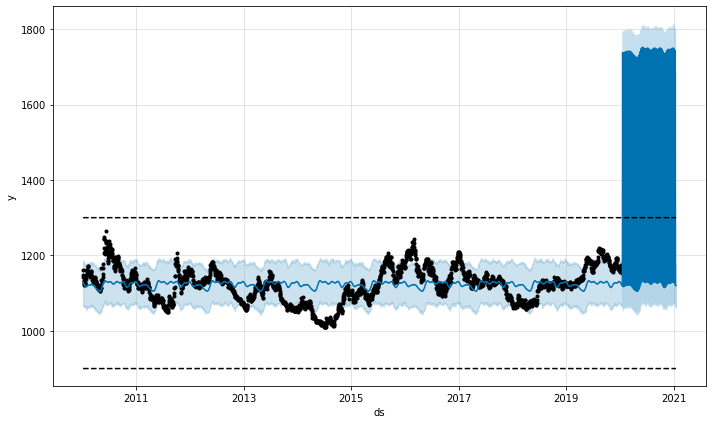

In [12]:
# 신뢰구간 표시
fig1 = model.plot(forecast)

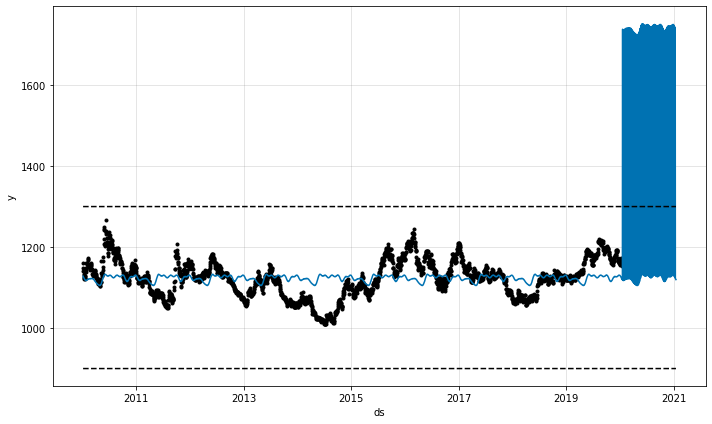

In [13]:
# 신뢰구간 제거
fig2 = model.plot(forecast, uncertainty=False)

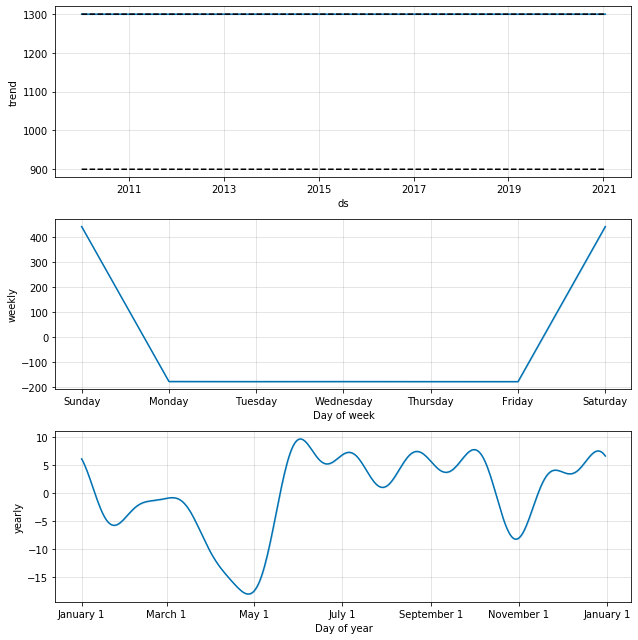

In [14]:
# 각각의 성분별로 분리
fig2 = model.plot_components(forecast)

<br><br>
<br><br>
<br><br>

### 9. Check Point

In [15]:
model.changepoints

79     2010-04-27
159    2010-08-20
238    2010-12-14
318    2011-04-11
397    2011-08-03
477    2011-11-30
556    2012-03-23
636    2012-07-19
715    2012-11-12
795    2013-03-12
874    2013-07-04
954    2013-11-01
1033   2014-02-26
1113   2014-06-25
1192   2014-10-22
1272   2015-02-13
1351   2015-06-12
1431   2015-10-07
1510   2016-01-29
1590   2016-05-31
1669   2016-09-26
1749   2017-01-17
1828   2017-05-17
1908   2017-09-08
1987   2018-01-09
Name: ds, dtype: datetime64[ns]

<br><br>
<br><br>
<br><br>

### 10. Check Point를 포함한 시각화

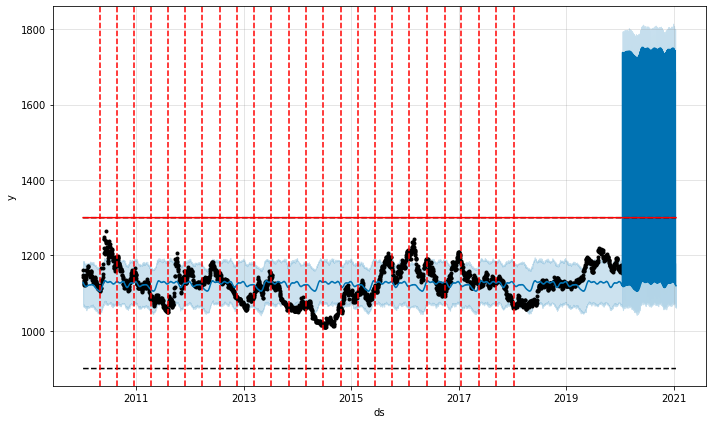

In [16]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast, threshold=0)
plt.show()

<br><br>
<br><br>
<br><br>

### 11. 2019년을 Testset으로 놓고 Fitting

In [17]:
# Data Loading
data = pd.read_csv('./data/DAILY_DATA.csv')
data = data[['date', 'USD']]
data.columns = ['ds', 'y']
data = data[0:2227]
data['cap'] = 1300
data['floor'] = 900

In [18]:
# 객체 생성
from fbprophet import Prophet
model = Prophet()
model.fit(data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
# 2019년 데이터 생성
future = model.make_future_dataframe(periods=365)
future['cap'] = 1300
future['floor'] = 900

In [20]:
# 2019년 데이터 생성
forecast = model.predict(future)

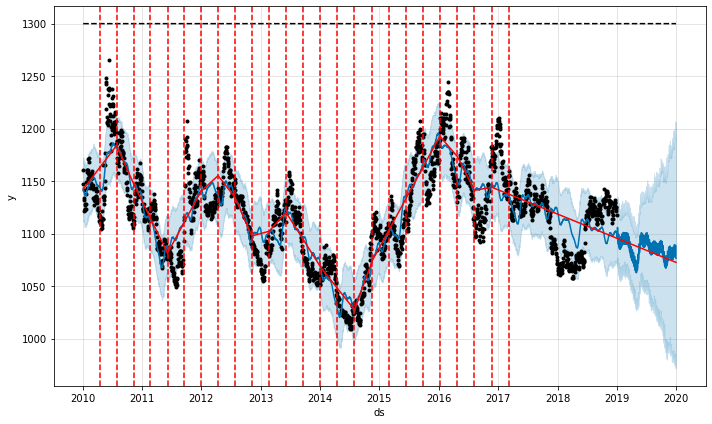

In [21]:
# 예측 시각화
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast, threshold=0)
plt.show()

<br><br>
<br><br>
<br><br>

### 12. 실제 2019년의 그래프와 비교

In [22]:
# prediction
y_pred = forecast[['ds', 'yhat']][2227:].set_index('ds')
y_pred.columns = ['y_pred']

In [23]:
# actual
data = pd.read_csv('./data/DAILY_DATA.csv')
data = data[['date', 'USD']]
data.columns = ['ds', 'y']
y_true = data[2227:2474].set_index('ds')
y_true.columns = ['y_true']

In [24]:
# concat
result = y_true.join(y_pred, how='outer').dropna()

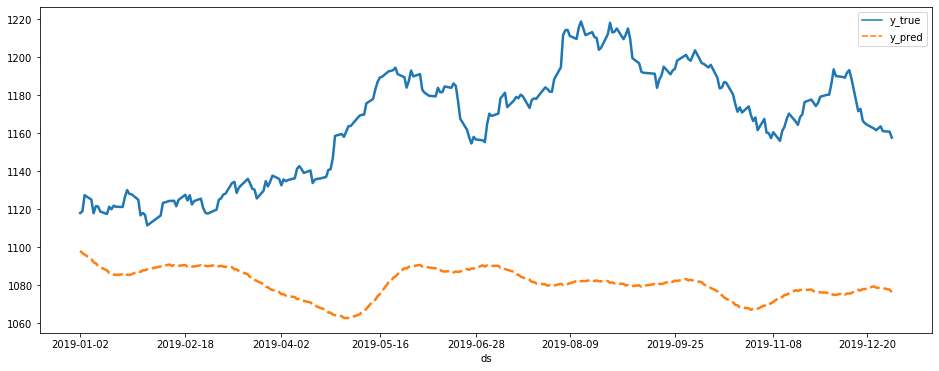

In [25]:
# Plot
plt.figure(figsize = (16,6))
ax = sns.lineplot(data = result, linewidth = 2.5)
ax.set(xticks=result.index[0::30])
plt.show()